# Creación de un ejemplo adversarial

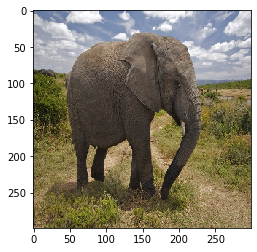

In [14]:

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.regularizers import l1_l2, l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array

import matplotlib.pyplot as plt
import numpy as np

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
#from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
##Funciones auxiliares
def plotImage( img, dims = False ):
    if not(dims):
        plt.imshow(img, vmin=0., vmax=1.)
    else: 
        plt.imshow(img.reshape(dims), vmin=0., vmax=1.)
    plt.show()
        
from keras.applications.inception_v3 import InceptionV3, decode_predictions

# instantiate model
keras.backend.set_learning_phase(0)
model = InceptionV3(weights='imagenet')

#Instanciacion del modelo resnet
#model = ResNet50(weights='imagenet')


##Imagen de elefante
img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(299, 299))
plotImage(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x_not_pre = x

# Imagen preprocesada para tener el formato que acepta resnet
#x = preprocess_input(x)




Eligamos una imagen para crear ejemplo adversarial

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


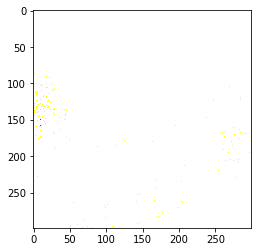

(1, 299, 299, 3)
Valor máximo 255
Valor mínimo 0


In [15]:
#select image to create an adversarial example from
plotImage(x[0])
print(x.shape)
print("Valor máximo %d" % np.max(x))
print("Valor mínimo %d" % np.min(x))

Veamos qué clasificacion da el modelo

In [16]:
preds = model.predict(x)
print(preds.shape)
print(np.argmax(preds[0]))
print('Predicción:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

(1, 1000)
725
Predicción: [('n03950228', 'pitcher', 1.0), ('n04131690', 'saltshaker', 1.0652771e-10), ('n04254777', 'sock', 9.602531e-17)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max valor absoluto del ruido 358.19362036962514


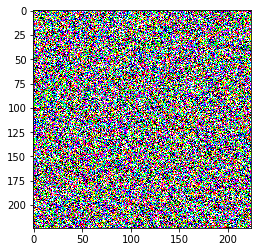

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen original


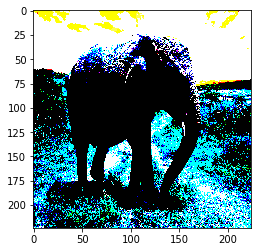

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen ruido


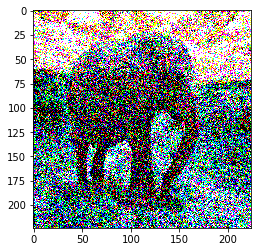

Predicted: [('n02504458', 'African_elephant', 0.4218912), ('n09256479', 'coral_reef', 0.12853439), ('n02999410', 'chain', 0.12396188)]


In [4]:
factor = 80
ruido = np.random.normal(loc=0.0, scale=1, size=x.shape)*factor
print('Max valor absoluto del ruido', np.max(np.abs(ruido)))
plotImage(ruido[0])
img_ruido = x + ruido
print("Imagen original")
plotImage(x[0])
print("Imagen ruido")
plotImage(img_ruido[0])
preds = model.predict(img_ruido)
print('Predicted:', decode_predictions(preds, top=3)[0])

In [5]:

#custom activation function for keeping adversarial pixel values between 0.0 and 1.0
def clip(x):
    return K.clip(x, 0.0, 1.0)

#custom loss funciton for non-targeted misclassification
def negative_categorical_crossentropy(yTrue,yPred):
    return 0.0 - K.categorical_crossentropy(yTrue,yPred)

#add custom objects to dictionary
get_custom_objects().update({'clip': Activation(clip)})
get_custom_objects().update({'negative_categorical_crossentropy': negative_categorical_crossentropy})

def define_adversarial_model(img_shape, regularization, classifier):
    h = img_shape[0]
    w = img_shape[1]
    numChannels = img_shape[2]
    
    #Input imagen base
    image = Input(shape=img_shape,name='image')
    #unidad para ruido adversarial
    one = Input(shape=(1,),name='unity')
    
    #Capa de ruido
    noise = Dense(h*w*numChannels,activation = None,use_bias=False,kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)
    
    #Cambia el shape del ruido igual al de la imagen
    noise = Reshape(img_shape, name='reshape')(noise)
    
    #Suma de las capas
    net = Add(name='add')([noise,image])
    
    #conecta imagen con ruido adversarial a classificador
    outputs = classifier(net)
    outputs = Reshape((1000,), name='reshape_resnet')(outputs)

    adversarial_model = Model(inputs=[image,one], outputs=outputs)
    #vuelve estáticos los parametros del classificador, solo entrena capa de ruido
    adversarial_model.layers[-1].trainable = False
    adversarial_model.layers[-2].trainable = False
    return adversarial_model

def entrena_modelo_adversarial(adversarial_model, target, img, num_epocas):
    target_vector = np.zeros(1000)
    target_vector[target] = 1.
    
    #callback para guardar el modelo 
    checkpoint = ModelCheckpoint('./adversarial_weights_resnet.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True,
                                mode='auto', period=1)
    #entrenamiento
    adversarial_model.fit(x={'image':img,'unity':np.ones(shape=(1,1))},y=target_vector.reshape(1,-1),epochs=num_epocas,verbose=2,
    callbacks=[checkpoint])
    
    #Carga mejores parametros
    adversarial_model.load_weights('./adversarial_weights_resnet.h5')
    
def recupera_ruido(adversarial_model):
    #quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((224,224,3)) * 255.) / 255.
    weights = adversarial_model.get_weights()[0].reshape((224,224,3))
    return weights

def clasifica_resnet(img):
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    prediccion =  model.predict(img)
    return decode_predictions(prediccion, top=3)[0]
def clasifica_mod_adversarial(inp, net):
    pred =  net.predict(inp)
    return decode_predictions(pred, top=3)[0]
#generate_adversary(x_not_pre,5,model,l1(0.01),'negative_categorical_crossentropy')


In [6]:
adversarial_model = define_adversarial_model((224,224,3),l1(0.0000001),model)
adversarial_model.compile(optimizer='nadam', loss='negative_categorical_crossentropy', metrics=[categorical_accuracy])

In [ ]:
target = 386
target_vector = np.zeros((1,1000))
target_vector[0, target] = 1
print(decode_predictions(target_vector, top = 3)[0])
entrena_modelo_adversarial(adversarial_model,target,x, 250)

[('n02504458', 'African_elephant', 1.0), ('n15075141', 'toilet_tissue', 0.0), ('n02317335', 'starfish', 0.0)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ruido
Valor absoluto máximo 0.8385825


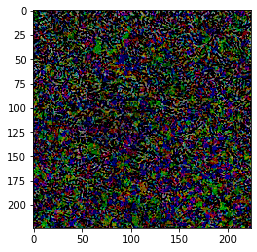

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen original


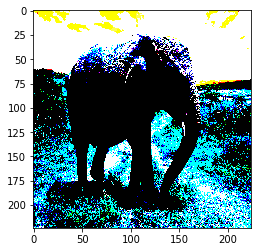

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen + ruido 


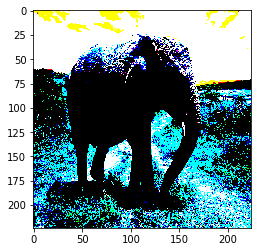

Prediccion img original [('n02504458', 'African_elephant', 0.86625427), ('n02504013', 'Indian_elephant', 0.06860924), ('n01871265', 'tusker', 0.06478469)]
1.7054911e-09
Predicción img adversarial [('n02504458', 'African_elephant', 0.8808223), ('n01871265', 'tusker', 0.06010792), ('n02504013', 'Indian_elephant', 0.05878987)]
[('n02504458', 'African_elephant', 0.8808223), ('n01871265', 'tusker', 0.06010792), ('n02504013', 'Indian_elephant', 0.05878987)]


In [10]:
#Recuperamos los parámetros de la capa de ruido
ruido = adversarial_model.get_weights()[0].reshape((224,224,3))
print('Ruido')
print('Valor absoluto máximo', np.max(np.abs(ruido)))
plotImage(ruido)
imagen_adversarial = x + ruido
print('Imagen original')
plotImage(x[0])
print('Imagen + ruido ')
plotImage(imagen_adversarial[0])
print('Prediccion img original',decode_predictions(model.predict(x), top=3)[0] )
pred_advs = model.predict(imagen_adversarial)[0]
print(pred_advs[target])
print('Predicción img adversarial',decode_predictions(model.predict(imagen_adversarial), top=3)[0])
print(clasifica_mod_adversarial({'image':x,'unity':np.ones(shape=(1,1))}, adversarial_model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


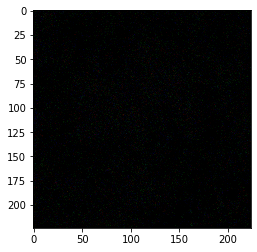

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('n02504458', 'African_elephant', 0.86655), ('n02504013', 'Indian_elephant', 0.06839117), ('n01871265', 'tusker', 0.06470819)]


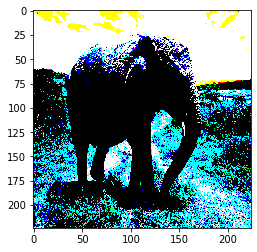

In [3]:
#adversarial_model.summary()
#np.save('imagen_adversarial_resnet', imagen_adversarial)
c = np.load('imagen_adversarial_resnet.npy')
#np.save('ruido_adversarial',ruido)
r = np.load('ruido_adversarial.npy')
plotImage(r)
print(decode_predictions(model.predict(c), top=3)[0])
plotImage(c[0])


In [ ]:
target_vector = np.zeros((1,1000))
target_vector[0,4] = 1
pred = model.predict(x)
print(np.argmax(pred))
print(np.argmax(target_vector))
print(adversarial_model.evaluate({'image':x,'unity':np.ones(shape=(1,1))}, target_vector))